In [5]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import math
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline

# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

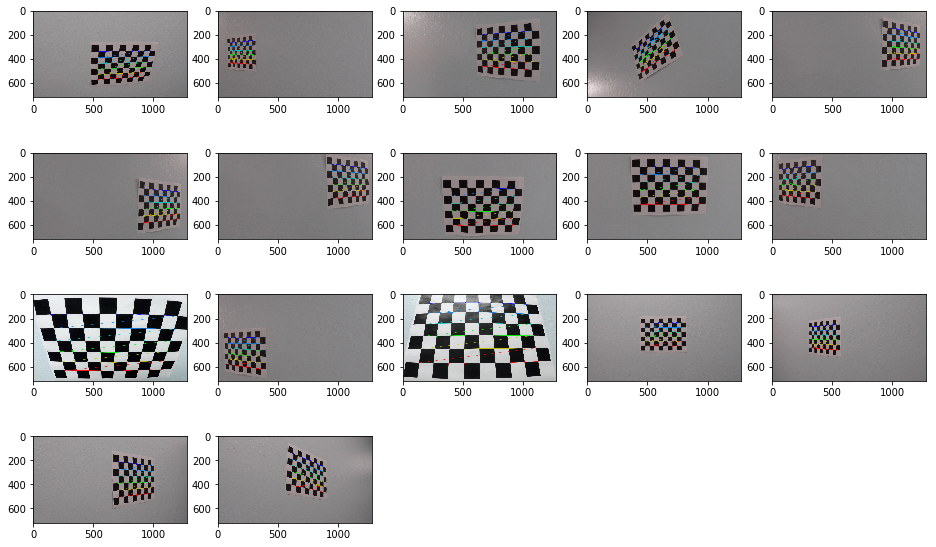

In [6]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig = plt.figure(figsize=(16, 10))

# Step through the list and search for chessboard corners
i = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        a = fig.add_subplot(math.ceil(float(len(images))/5.), 5, i+1)
        plt.imshow(img)
        i+=1
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Example of undistorted images:

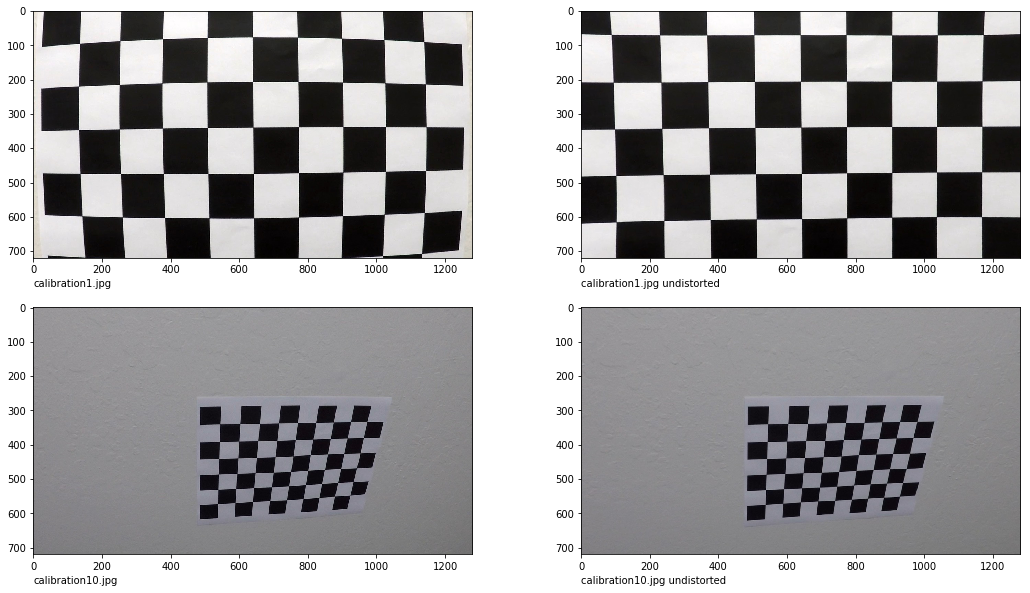

In [7]:
sample_images = images[0:2]
fig = plt.figure(figsize=(18, 10))

i = 0
for fname in sample_images:
    name = os.path.basename(fname)
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    a = fig.add_subplot(math.ceil(float(len(sample_images))/2.)*2, 2, i+1)
    plt.imshow(img)
    plt.text(0, 805, name)
    i+=1

    a = fig.add_subplot(math.ceil(float(len(sample_images))/2.)*2, 2, i+1)
    plt.imshow(dst)
    plt.text(0, 805, "{} undistorted".format(name))
    i+=1

### Calibrate test images

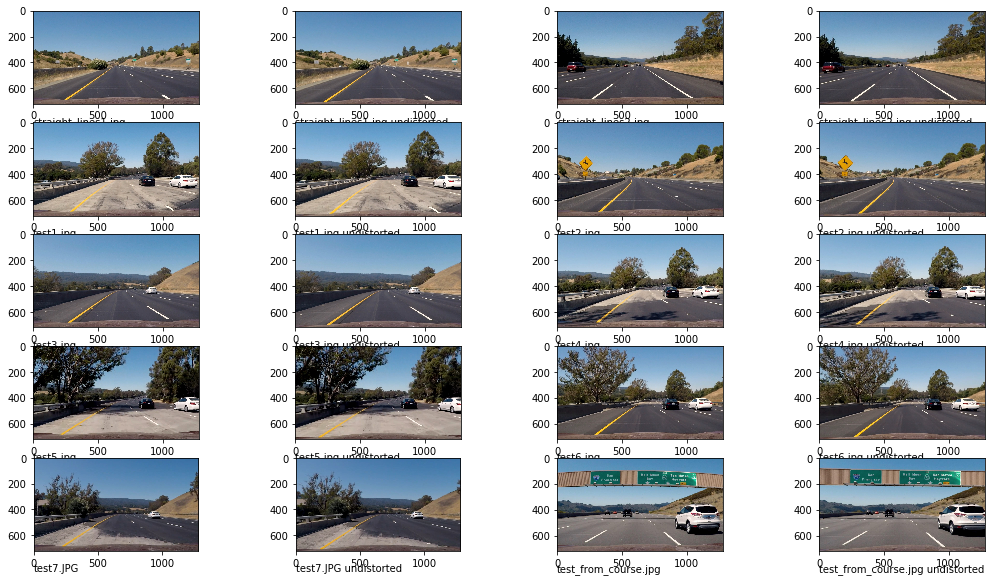

In [8]:
test_images = glob.glob('test_images/*.jpg')
dsts = []
fig = plt.figure(figsize=(18, 12))

i = 0
for fname in test_images:
    name = os.path.basename(fname)
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    dsts.append(dst)
    a = fig.add_subplot(math.ceil(float(len(test_images))/4.)*2, 4, i+1)
    plt.imshow(img)
    plt.text(0, 880, name)
    i+=1

    a = fig.add_subplot(math.ceil(float(len(test_images))/4.)*2, 4, i+1)
    plt.imshow(dst)
    plt.text(0, 880, "{} undistorted".format(name))
    i+=1

### Thresholded binary images

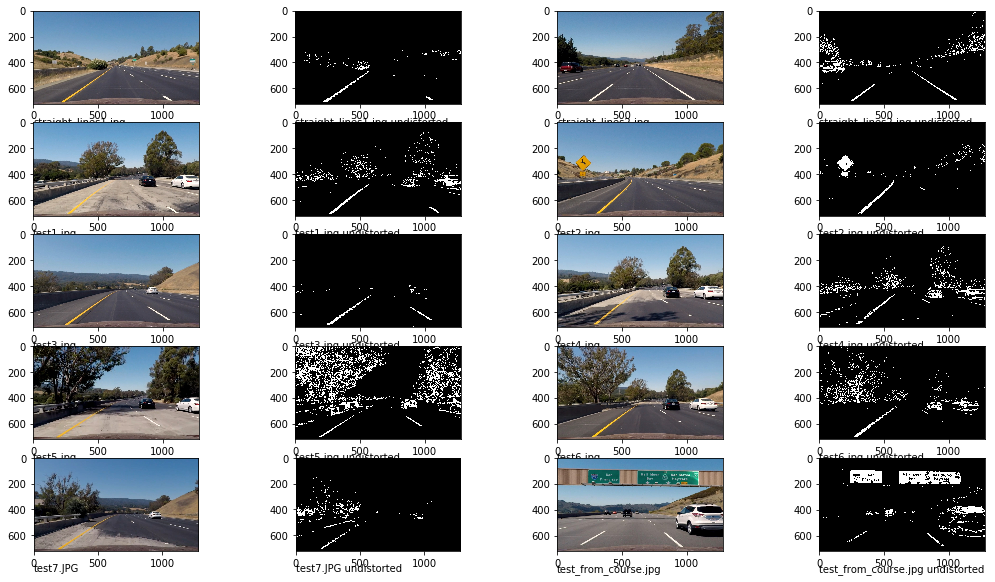

In [9]:
fig = plt.figure(figsize=(18, 12))

def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 150)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

i = 0
binaries = []
for j, img in enumerate(dsts):
    name = os.path.basename(test_images[j])
    comb = pipeline(img)
    binaries.append(comb)
    a = fig.add_subplot(math.ceil(float(len(dsts))/4.)*2, 4, i+1)
    plt.imshow(img)
    plt.text(0, 880, name)
    i+=1

    a = fig.add_subplot(math.ceil(float(len(dsts))/4.)*2, 4, i+1)
    plt.imshow(comb, cmap='gray')
    plt.text(0, 880, "{} undistorted".format(name))
    i+=1

### Perspective transformation

#### Finding a good source and destination coordinates

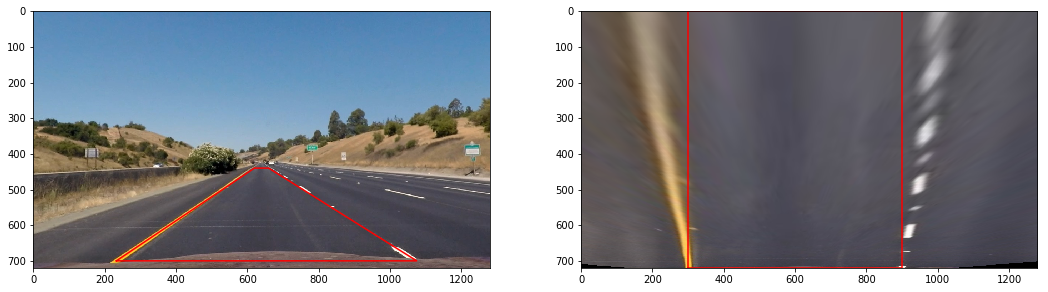

In [10]:
fig = plt.figure(figsize=(18, 6))

img = dsts[0]
img_size = (img.shape[1], img.shape[0])

src = np.float32([[233,700],
                 [620,440],
                 [660,440],
                 [1075,700]])

dst = np.float32([[300,719],
                 [300,0],
                 [900,0],
                 [900,719]])

a = fig.add_subplot(1, 2, 1)
plt.imshow(img)
a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size)

a = fig.add_subplot(1, 2, 2)
plt.imshow(warped)
_ = a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')

### Find lines

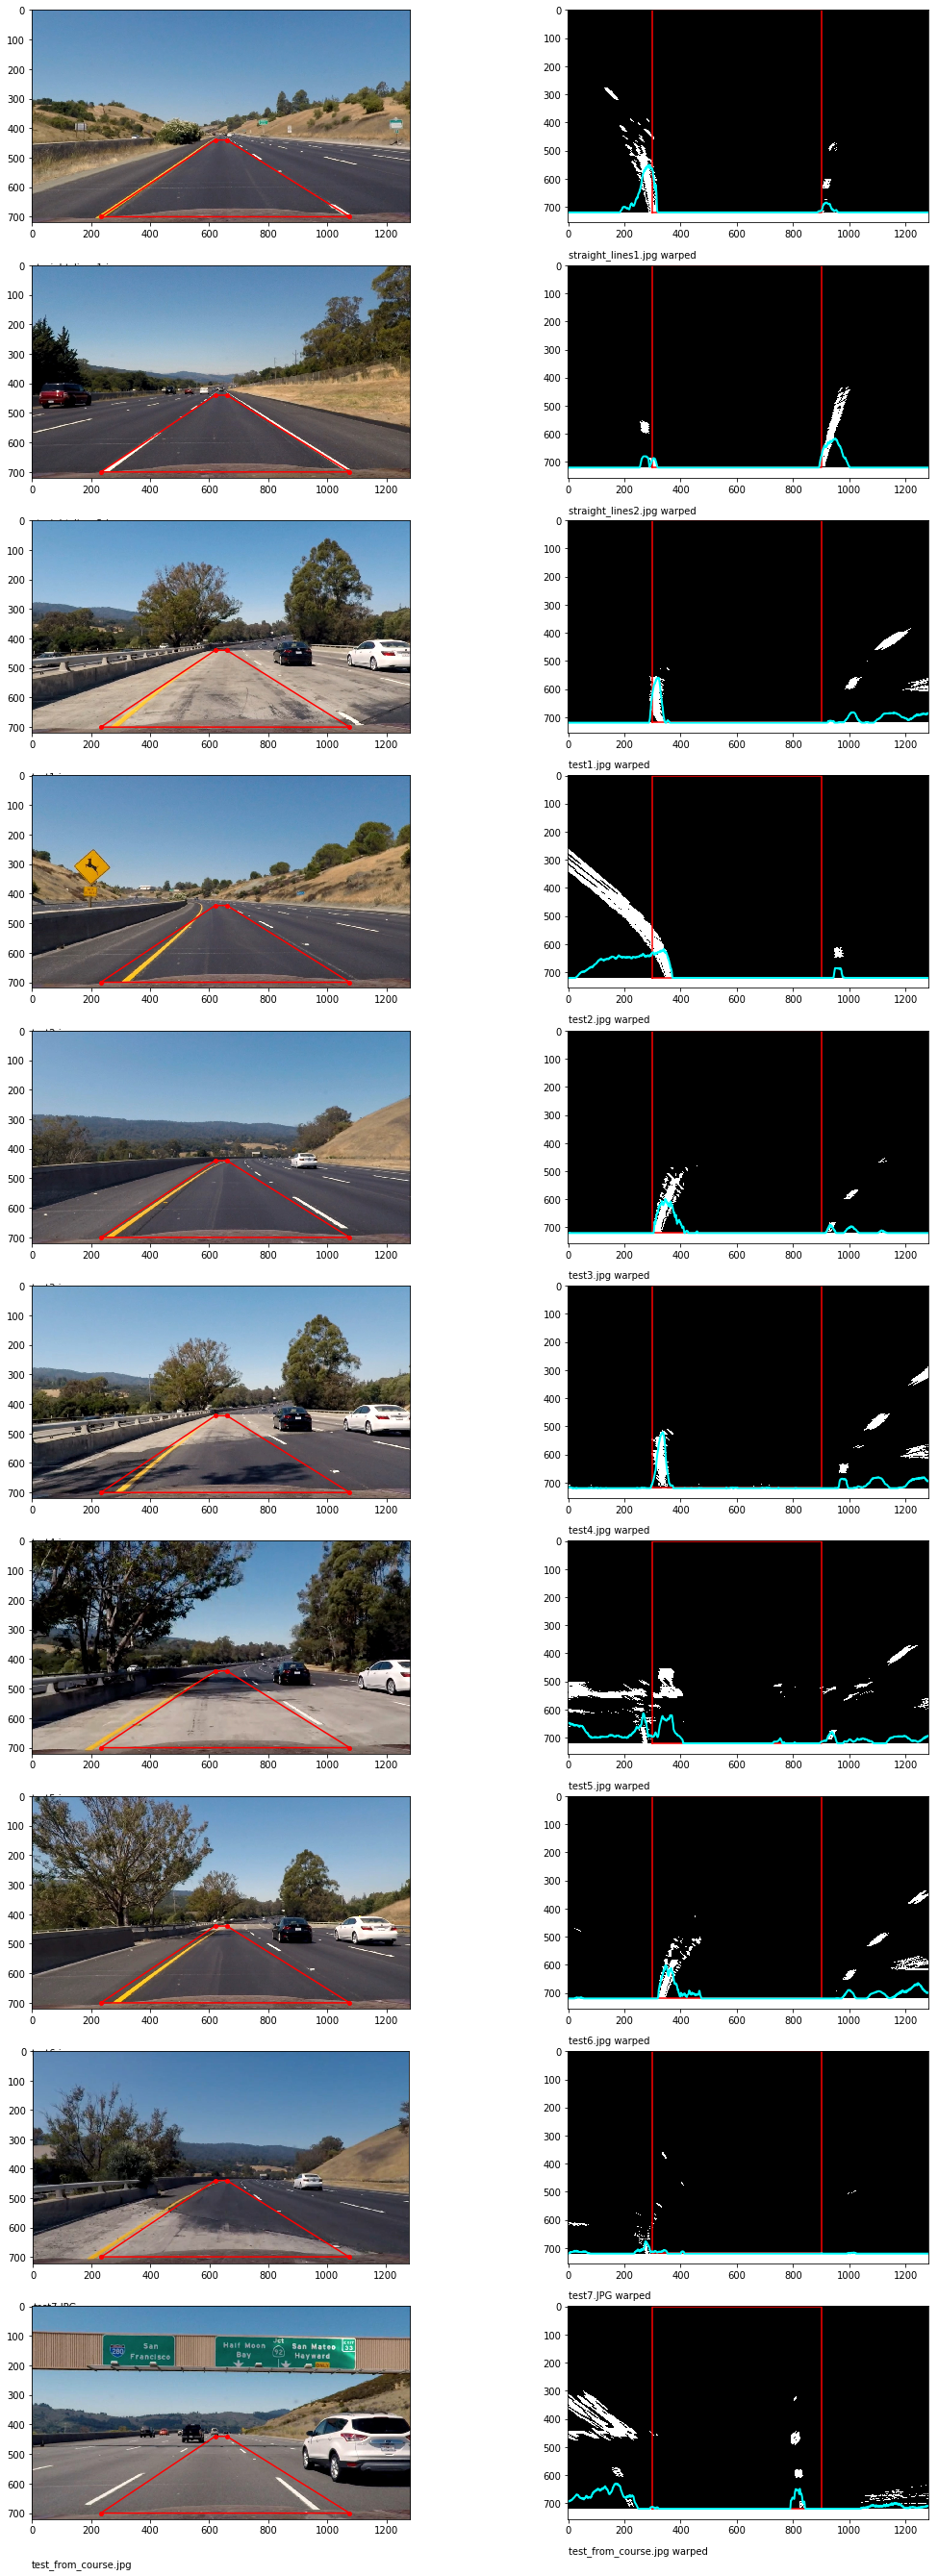

In [11]:
fig = plt.figure(figsize=(18, 48))
img = dsts[0]
nwindows = 9
margin = 100
minpix = 50

img_size = (img.shape[1], img.shape[0])    

# to cover same y-range as image
ploty = np.linspace(0, img_size[1]-1, num=img_size[1])

warpeds = []
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

i = 0
sample = dsts
for j, img in enumerate(sample):
    
    name = os.path.basename(test_images[j])
    a = fig.add_subplot(math.ceil(float(len(dsts))/2.)*2, 2, i+1)
    plt.imshow(img)
    a.plot(src[:,0], src[:,1], 'or', ms=4)
    a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')
    plt.text(0, 880, name)
    i+=1
    
    binary_warped = cv2.warpPerspective(binaries[j], M, img_size)
    warpeds.append(binary_warped*255)
    a = fig.add_subplot(math.ceil(float(len(dsts))/2.)*2, 2, i+1)

    left_lane_inds = []
    right_lane_inds = []
    
    histogram = np.sum(binary_warped[int(warped.shape[0]/2):,:], axis=0)
    
    plt.imshow(binary_warped, cmap='gray')
    a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')

    # Subtract histogram values from max values so the histogram can be drawn
    # at the bottom of the plot.
    a.plot(binary_warped.shape[0] - histogram, '-', c='#00FFFF', lw=2)
    plt.text(0, 880, "{} warped".format(name))
    i+=1

### Fitting a polynomial

---

#### Sliding Window

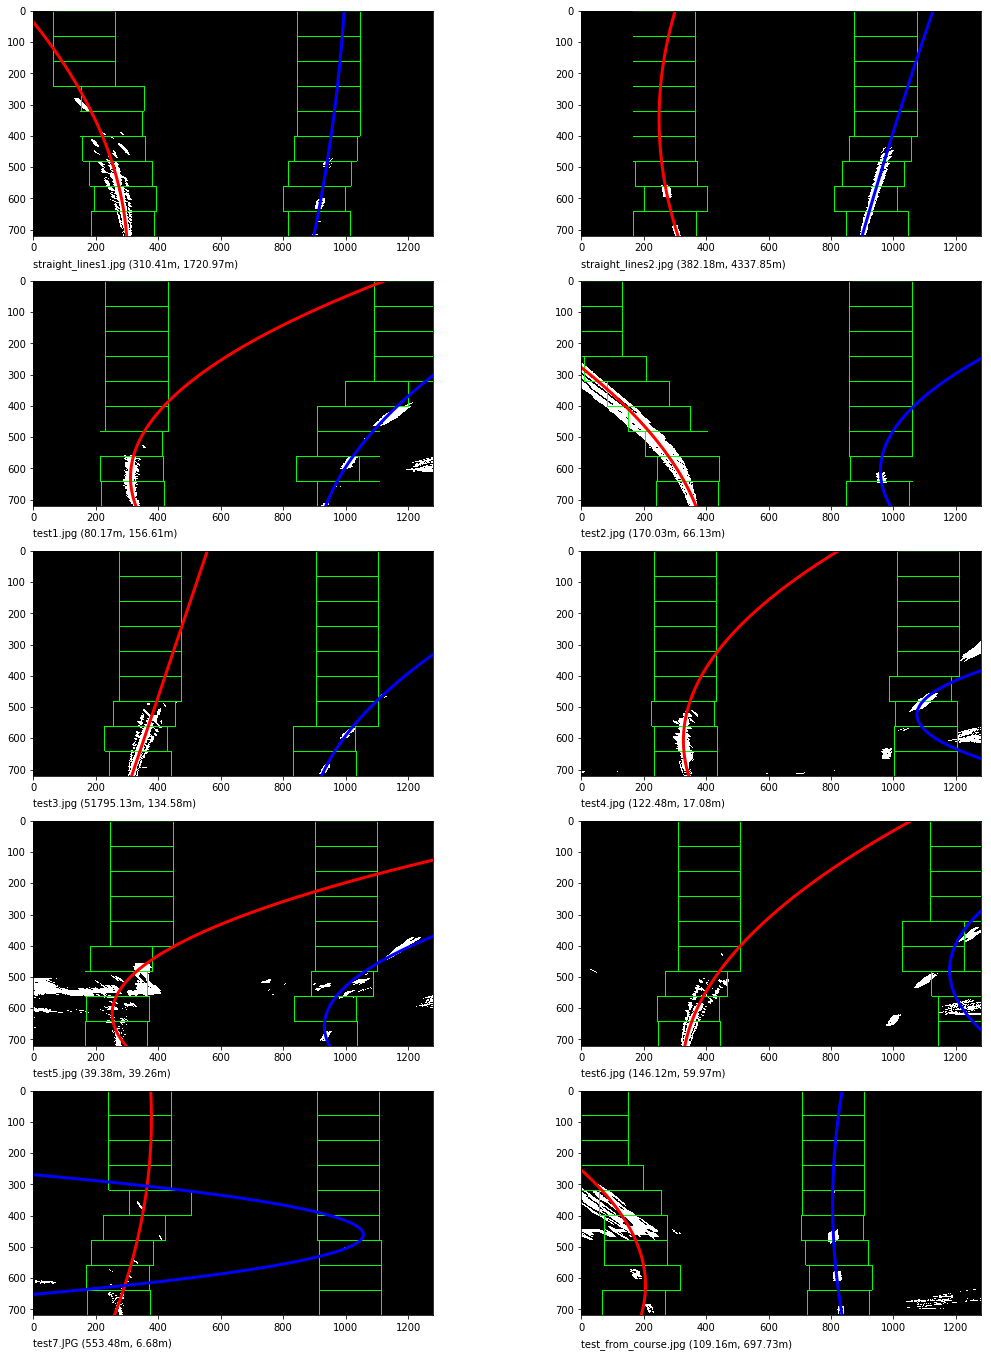

In [12]:
fig = plt.figure(figsize=(18, 24))
img = dsts[0]
nwindows = 9
margin = 100
minpix = 50

img_size = (img.shape[1], img.shape[0])    

# to cover same y-range as image
ploty = np.linspace(0, img_size[1]-1, num=img_size[1])

i = 0
sample = dsts
for j, img in enumerate(sample):
    
    name = os.path.basename(test_images[j])
    
    M = cv2.getPerspectiveTransform(src, dst)
    binary_warped = cv2.warpPerspective(binaries[j], M, img_size)

    a = fig.add_subplot(math.ceil(float(len(dsts))/2.), 2, i+1)

    left_lane_inds = []
    right_lane_inds = []
    
    histogram = np.sum(binary_warped[int(warped.shape[0]/2):,:], axis=0)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # At this point, leftx_base and rightx_base should contain x position of each respective line.
    
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # An array of y value from 0 to (image height - 1)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Calculate x of each pixel position
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.plot(left_fitx, ploty, color='red', linewidth=3)
    plt.plot(right_fitx, ploty, color='blue', linewidth=3)
    
    plt.imshow(out_img, cmap='gray')
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    left_y_eval = np.max(lefty)
    right_y_eval = np.max(righty)
    left_curverad = ((1 + (2*left_fit[0]*left_y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*right_y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    plt.text(0, 820, "{} ({:.2f}m, {:.2f}m)".format(name, left_curverad, right_curverad))
    i+=1

#### Window search with convolution

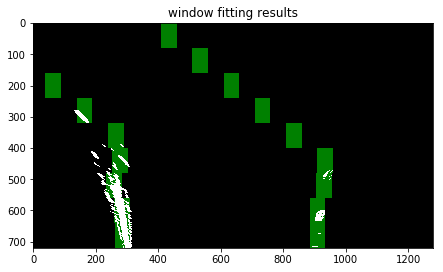

In [13]:
fig = plt.figure(figsize=(18, 24))
    
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
cols = 2
rows = math.ceil(float(len(dsts))/cols)

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

i = 0
sample = warpeds[0:1]
for j, warped in enumerate(sample):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    a = fig.add_subplot(rows, cols, i+1)
    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')

## Refactor into a class

This class should then be usable in other projects

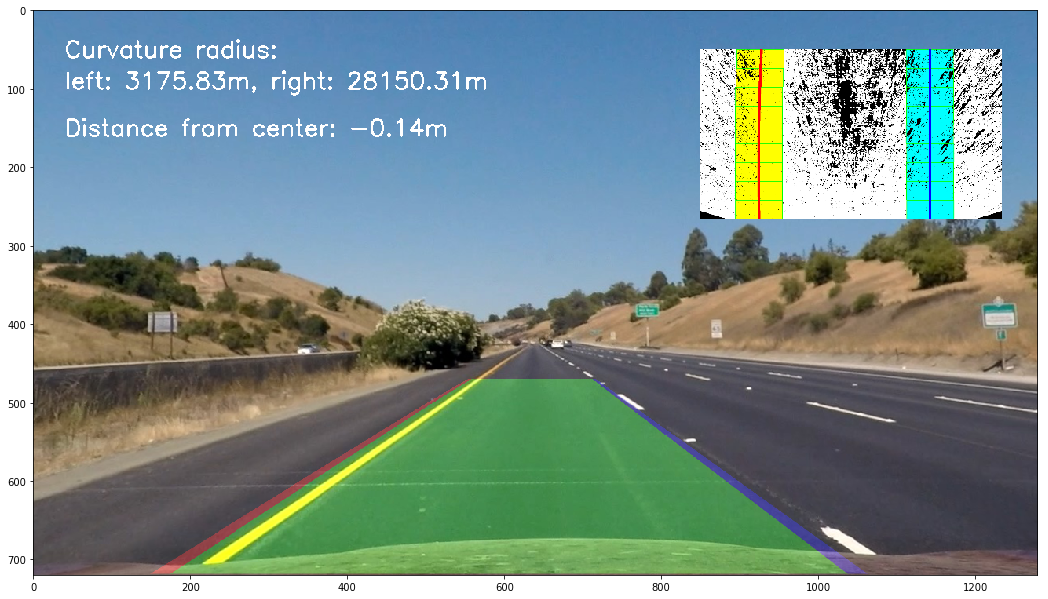

In [14]:
def example():
    ip = ImagePipeline(input_color='bgr')
#     ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
    # If mtx and dist have been initialized, we can set them directly.
    ip.mtx = mtx
    ip.dist = dist

    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])

    dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])

    ip.set_perspective(src, dst)

    t1 = Threshold(trange=(0.3, 1.7))
    t1.add(Color(['l', 'r', 'g']))
    t1.add(Sobel('y', kernel=3))
    t1.add(Sobel('x', kernel=3))
    t1.add(Direction())

    t2 = Threshold(trange=(30, 130))
    t2.add(Color(['l', 'r', 'g']))
    t2.add(Sobel('y', kernel=3))
    t2.add(Magnitude())

    ip.add(t1)
    ip.add(t2)
    c = Combinator(f=(lambda ths: np.where((ths[0] == 1) | (ths[1] == 1))))
    ip.add(c)
    
    f = FindLinesSlidingWindows()
    ip.add(f)
    
    a = Annotate(f)
    ip.add(a)

    img = cv2.imread(test_images[0])
    
    fig = plt.figure(figsize=(18, 12))
    plt.imshow(ip.process(img))

example()

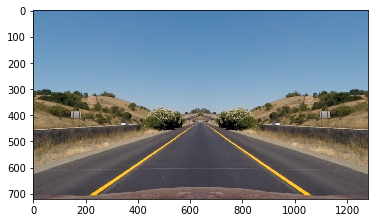

In [15]:
def mirror(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    size = (undist.shape[1], undist.shape[0])
    return np.concatenate((undist[:,:int(size[0]/2),:], np.fliplr(undist[:,:int(size[0]/2),:])), axis=1)
    # Another side
#     return np.concatenate((np.fliplr(undist[:,int(size[0]/2):,:]), undist[:,int(size[0]/2):,:]), axis=1)
img = cv2.imread(test_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_ = plt.imshow(mirror(img))

[[  100.   719.]
 [  542.   470.]
 [  738.   470.]
 [ 1180.   719.]]
[[  120.   720.]
 [  120.     0.]
 [ 1160.     0.]
 [ 1160.   720.]]


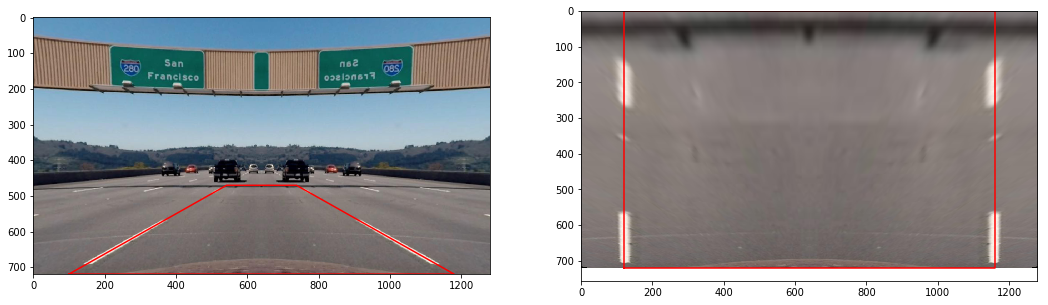

In [16]:
def adjust_perspective(change=None):
    src = np.float32(
          [[src_x2_i.value[0], src_y2_i.value],
           [src_x1_i.value[0], src_y1_i.value],
           [src_x1_i.value[1], src_y1_i.value],
           [src_x2_i.value[1], src_y2_i.value]])
    dst = np.float32(
          [[dst_x_i.value[0], dst_y_i.value[1]],
           [dst_x_i.value[0], dst_y_i.value[0]],
           [dst_x_i.value[1], dst_y_i.value[0]],
           [dst_x_i.value[1], dst_y_i.value[1]]])
    
    img = cv2.imread('test_images/test_from_course.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist = mirror(undist)
    shape = undist.shape
    im_size = (shape[1], shape[0])
    
    fig = plt.figure(figsize=(18, 6))

    a = fig.add_subplot(1, 2, 1)
    plt.imshow(undist)
    a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, im_size)

    a = fig.add_subplot(1, 2, 2)
    plt.imshow(warped)
    _ = a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')
    clear_output(True)
    print(src)
    print(dst)
    

# src_x1_i = IntRangeSlider(description='src x - top', min=0, max=im_size[0], step=1,value=[589, 690])
# src_x2_i = IntRangeSlider(description='src x - bottom', min=0, max=im_size[0], step=1,value=[206, 1076])
# src_y1_i = IntSlider(description='src y - top', min=0, max=im_size[1], step=1,value=470)
# src_y2_i = IntSlider(description='src y - bottom', min=0, max=im_size[1], step=1,value=719)

# dst_x_i = IntRangeSlider(description='dst x', min=0, max=im_size[0], step=1,value=[300, 962])
# dst_y_i = IntRangeSlider(description='dst y', min=0, max=im_size[1], step=1,value=[0, 719])

src_x1_i = IntRangeSlider(description='src x - top', min=0, max=1280, step=1,value=[542, 738])
src_x2_i = IntRangeSlider(description='src x - bottom', min=0, max=1280, step=1,value=[100, 1180])
src_y1_i = IntSlider(description='src y - top', min=0, max=720, step=1,value=470)
src_y2_i = IntSlider(description='src y - bottom', min=0, max=720, step=1,value=719)

# dst_x_i = IntRangeSlider(description='dst x', min=0, max=1280, step=1,value=[300, 980])
dst_x_i = IntRangeSlider(description='dst x', min=0, max=1280, step=1,value=[120, 1160])
dst_y_i = IntRangeSlider(description='dst y', min=0, max=720, step=1,value=[0, 720])

src_x1_i.observe(adjust_perspective, 'value')
src_x2_i.observe(adjust_perspective, 'value')
src_y1_i.observe(adjust_perspective, 'value')
src_y2_i.observe(adjust_perspective, 'value')

dst_x_i.observe(adjust_perspective, 'value')
dst_y_i.observe(adjust_perspective, 'value')

display(src_x1_i, src_x2_i, src_y1_i, src_y2_i, dst_x_i, dst_y_i)
adjust_perspective()

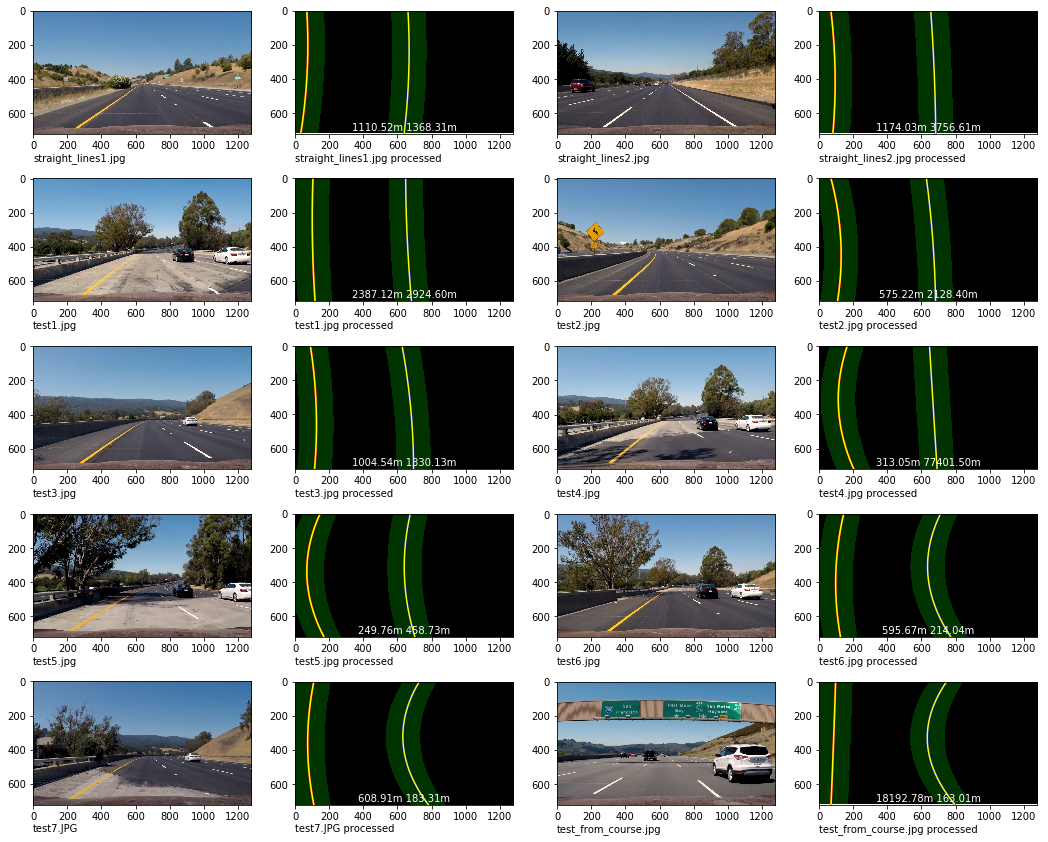

TypeError: expected non-empty vector for x

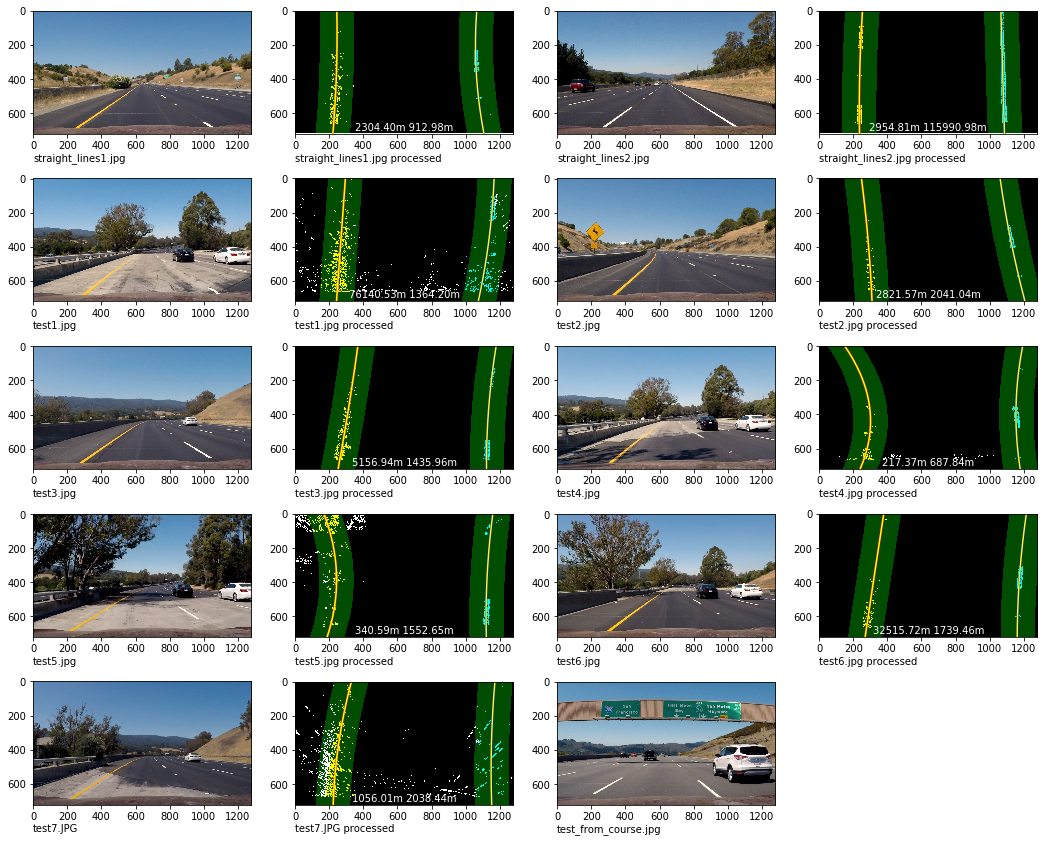

In [17]:
def adjust_thresholds(change=None):
    """
    combiner values: "dir", "mag", None
    """
    r=r_i.value
    g=g_i.value
    b=b_i.value
    h=h_i.value
    l=l_i.value
    s=s_i.value
    y=y_i.value
    u=u_i.value
    v=v_i.value
    sobel_x=sobel_x_i.value
    sobel_y=sobel_y_i.value
    sobel_x_kernel=sobel_y_i.value
    sobel_y_kernel=sobel_y_kernel_i.value
    combiner=combiner_i.value
    mag_or_sobel_range=mag_or_sobel_range_i.value
    dir_range=dir_range_i.value
    
    ip = ImagePipeline(input_color='bgr')
    # ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
    ip.mtx = mtx
    ip.dist = dist

    src = np.float32([[  100.,   719.],
                      [  542.,   470.],
                      [  738.,   470.],
                      [ 1180.,   719.]])

    dst = np.float32([[ 120.,  720.],
                      [ 120.,    0.],
                      [ 1160.,    0.],
                      [ 1160.,  720.]])

    ip.set_perspective(src, dst)
            
    if combiner == 'dir':
        t = Threshold(trange=dir_range, crop_b=50)
    else:
        t = Threshold(trange=mag_or_sobel_range, crop_b=50)
        
    cc = []
    if r:
        cc.append('r')
    if g:
        cc.append('g')
    if b:
        cc.append('b')
    if h:
        cc.append('h')
    if l:
        cc.append('l')
    if s:
        cc.append('s')
    if y:
        cc.append('y')
    if u:
        cc.append('u')
    if v:
        cc.append('v')
    
    t.add(Color(cc))
    
    if sobel_x:
        t.add(Sobel('x', kernel=sobel_x_kernel))
    
    if sobel_y:
        t.add(Sobel('y', kernel=sobel_y_kernel))
        
    if combiner == 'dir':
        t.add(Direction())
    elif combiner == 'mag':
        t.add(Magnitude())
            
    ip.add(t)
    c = Combinator(f=(lambda ths: np.where((ths[0] == 1))))
    ip.add(c)
    f = FindLinesSlidingWindows(always_recalculate=True)
    ip.add(f)
    
    test_images = glob.glob('test_images/*.jpg')

    fig = plt.figure(figsize=(18, 18))
    i = 0
    for fname in test_images:
        name = os.path.basename(fname)
        img = cv2.imread(fname)
        
        a = fig.add_subplot(math.ceil(float(len(test_images))/4.)*2, 4, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.text(0, 880, name)
        i+=1

        processed = ip.process(img)
        a = fig.add_subplot(math.ceil(float(len(test_images))/4.)*2, 4, i+1)
        plt.imshow(processed, cmap='gray')
        plt.plot(f.left_fitx, f.ploty, color='red', linewidth=2)
        plt.plot(f.right_fitx, f.ploty, color='blue', linewidth=2)
        
        binary_warped = processed
        nonzero = binary_warped.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        left_lane_inds = f.left_lane_inds
        right_lane_inds = f.right_lane_inds
        left_fitx = f.left_fitx
        right_fitx = f.right_fitx
        ploty = f.ploty
        margin = f.subsequent_search_margin
        
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 255, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.text(0, 880, "{} processed".format(name))
        plt.text(640, 700, "{:.2f}m {:.2f}m".format(f.left_curverad_m, f.right_curverad_m), color='white', ha='center')
        i+=1
    clear_output(True)


r_i = Checkbox(description='r', value=False)
g_i = Checkbox(description='g', value=False)
b_i = Checkbox(description='b', value=False)
h_i = Checkbox(description='h', value=False)
l_i = Checkbox(description='l', value=False)
s_i = Checkbox(description='s', value=True)
y_i = Checkbox(description='y', value=False)
u_i = Checkbox(description='u', value=False)
v_i = Checkbox(description='v', value=False)
sobel_x_i = Checkbox(description='sobel x', value=True)
sobel_y_i = Checkbox(description='sobel y', value=True)
sobel_x_kernel_i = IntSlider(description='sobel x kernel', min=1, max=31, step=2, value=3)
sobel_y_kernel_i = IntSlider(description='sobel y kernel', min=1, max=31, step=2, value=3)
combiner_i = RadioButtons(description='combiner', options=[None, 'mag', 'dir'], value='mag')
mag_or_sobel_range_i = IntRangeSlider(description='mag or sobel range', min=0, max=512, step=1, value=[8, 137])
dir_range_i = FloatRangeSlider(description='dir range', min=0, max=np.pi / 2, step=0.01,value=[0.7, 1.3])

r_i.observe(adjust_thresholds, 'value')
g_i.observe(adjust_thresholds, 'value')
b_i.observe(adjust_thresholds, 'value')
h_i.observe(adjust_thresholds, 'value')
l_i.observe(adjust_thresholds, 'value')
s_i.observe(adjust_thresholds, 'value')
y_i.observe(adjust_thresholds, 'value')
u_i.observe(adjust_thresholds, 'value')
v_i.observe(adjust_thresholds, 'value')
sobel_x_i.observe(adjust_thresholds, 'value')
sobel_y_i.observe(adjust_thresholds, 'value')
sobel_x_kernel_i.observe(adjust_thresholds, 'value')
sobel_y_kernel_i.observe(adjust_thresholds, 'value')
combiner_i.observe(adjust_thresholds, 'value')
mag_or_sobel_range_i.observe(adjust_thresholds, 'value')
dir_range_i.observe(adjust_thresholds, 'value')

display(r_i, g_i, b_i, h_i, l_i, s_i, y_i, u_i, v_i, sobel_x_i, sobel_y_i, sobel_x_kernel_i, sobel_y_kernel_i, combiner_i,
        mag_or_sobel_range_i, dir_range_i)
adjust_thresholds()

In [ ]:
ip_final = ImagePipeline(input_color='bgr')

src = np.float32([[  100.,   719.],
                  [  542.,   470.],
                  [  738.,   470.],
                  [ 1180.,   719.]])

dst = np.float32([[ 120.,  720.],
                  [ 120.,    0.],
                  [ 1160.,    0.],
                  [ 1160.,  720.]])

ip_final.set_perspective(src, dst)
# ip_final.calibrate(glob.glob('camera_cal/calibration*.jpg'))
ip_final.mtx = mtx
ip_final.dist = dist

t1 = Threshold(trange=(8, 137))
t1.add(Color(['s']))
t1.add(Sobel('y', kernel=3))
t1.add(Sobel('x', kernel=3))
t1.add(Magnitude())

# t2 = Threshold(trange=(5, 47))
# t2.add(Color(['s']))
# t2.add(Sobel('y', kernel=19))
# t2.add(Sobel('x', kernel=19))
# t2.add(Magnitude())

# t2 = Threshold(trange=(4, 130))
# t2.add(Color(['s']))
# t2.add(Sobel('y', kernel=3))

ip_final.add(t1)
# ip_final.add(t2)
# c = Combinator(f=(lambda ths: np.where((ths[0] == 1) & (ths[1] == 1))))
c = Combinator(f=(lambda ths: np.where((ths[0] == 1))))
ip_final.add(c)
f = FindLinesSlidingWindows(always_recalculate=True)
ip_final.add(f)

a = Annotate(f)
ip_final.add(a)

test_images = glob.glob('test_images/*.jpg')

fig = plt.figure(figsize=(18, 10))
i = 0
for fname in test_images:
    name = os.path.basename(fname)
    img = cv2.imread(fname)

    processed = ip_final.process(img)
    a = fig.add_subplot(math.ceil(float(len(test_images))/4.), 4, i+1)
    plt.imshow(processed)

    plt.text(0, 880, "{} processed".format(name))
    plt.text(0, 960, "{:.2f}m".format(f.left_curverad_m), color='red')
    plt.text(1280, 960, "{:.2f}m".format(f.right_curverad_m), color='blue', horizontalalignment='right')
    i+=1

## Videos

In [2]:
ip_vid = ImagePipeline(input_color='rgb')

src = np.float32([[  100.,   719.],
                  [  542.,   470.],
                  [  738.,   470.],
                  [ 1180.,   719.]])

dst = np.float32([[ 120.,  720.],
                  [ 120.,    0.],
                  [ 1160.,    0.],
                  [ 1160.,  720.]])

ip_vid.set_perspective(src, dst)
ip_vid.calibrate(glob.glob('camera_cal/calibration*.jpg'))
# ip_vid.mtx = mtx
# ip_vid.dist = dist

#     mask[v_cutoff:, :][((s_x >= 25) & (s_x <= 255) &
#                         (s_y >= 25) & (s_y <= 255)) |
#                        ((grad_mag >= 30) & (grad_mag <= 512) &
#                         (grad_dir >= 0.2) & (grad_dir <= 1.)) |
#                        (ylw == 255) |
#                        (highlights == 255)] = 1

# sx    
t0 = Threshold(trange=(25, 255))
t0.add(Color(['u', 'v', 's']))
t0.add(Sobel('x', kernel=3))

ip_vid.add(t0)

# sy
t1 = Threshold(trange=(25, 255))
t1.add(Color(['u', 'v', 's']))
t1.add(Sobel('y', kernel=3))

ip_vid.add(t1)

# grad_mag
t2 = Threshold(trange=(30, 512))
t2.add(Color(['u', 'v', 's']))
t2.add(Sobel('x', kernel=3))
t2.add(Sobel('y', kernel=3))
t2.add(Magnitude())

ip_vid.add(t2)

# grad_dir
t3 = Threshold(trange=(0.2, 1.))
t3.add(Color(['u', 'v', 's']))
t3.add(Sobel('x', kernel=3))
t3.add(Sobel('y', kernel=3))
t3.add(Direction())

ip_vid.add(t3)

# yellow
t4 = Threshold()
t4.add(Color(['h2', 's2', 'v2'], in_range=((20, 50, 150), (40, 255, 255)), gray=False))

ip_vid.add(t4)

# highlight
t5 = Threshold()
t5.add(Color(['r'], in_range=((lambda img: int(np.percentile(img, 99.9) - 30)), 255), gray=False))

ip_vid.add(t5)

c = Combinator(f=(lambda ths: np.where(
    ((ths[0] == 1) & (ths[1] == 1)) |
    ((ths[2] == 1) & (ths[3] == 1)) |
    (ths[4] == 255) | (ths[5] == 255)  
)))
ip_vid.add(c)
f = FindLinesSlidingWindows(always_recalculate=False,
                            ok_curverad_diff_m_max=1000,
                            alpha=0.1)
ip_vid.add(f)

a = Annotate(f)
ip_vid.add(a)

In [3]:
output = 'project_video_processed.mp4'
clip2 = VideoFileClip('project_video.mp4')

ip_vid = ImagePipeline(input_color='rgb')

src = np.float32([[  100.,   719.],
                  [  542.,   470.],
                  [  738.,   470.],
                  [ 1180.,   719.]])

dst = np.float32([[ 120.,  720.],
                  [ 120.,    0.],
                  [ 1160.,    0.],
                  [ 1160.,  720.]])

ip_vid.set_perspective(src, dst)
# ip_final.calibrate(glob.glob('camera_cal/calibration*.jpg'))
ip_vid.mtx = mtx
ip_vid.dist = dist

t1 = Threshold(trange=(11, 137))
t1.add(Color(['s']))
t1.add(Sobel('y', kernel=3))
t1.add(Sobel('x', kernel=3))
t1.add(Magnitude())

ip_vid.add(t1)
c = Combinator(f=(lambda ths: np.where((ths[0] == 1))))
ip_vid.add(c)
f = FindLinesSlidingWindows(always_recalculate=False,
                            ok_curverad_diff_m_max=1000,
                            alpha=0.1)
ip_vid.add(f)

a = Annotate(f)
ip_vid.add(a)

clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

In [4]:
output = 'project_video_processed.mp4'
clip2 = VideoFileClip('project_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:01<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

Wall time: 9min 2s


In [ ]:
output = 'challenge_video_processed.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)

In [ ]:
output = 'harder_challenge_video_processed.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
clip = clip2.fl_image(ip_vid.process)
%time clip.write_videofile(output, audio=False)